In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv("Train_SU63ISt.csv")

In [4]:
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [22]:
df = pd.read_csv('Train_SU63ISt.csv', nrows = 11856)

In [23]:
train=df[0:10392] 
test=df[10392:]

In [24]:
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

/home/anonymous/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/home/anonymous/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.
/home/anonymous/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


In [25]:
df.head()

,ID,Count
Datetime,,
2012-08-25,11.5,3.166667
2012-08-26,35.5,3.666667
2012-08-27,59.5,2.583333
2012-08-28,83.5,2.416667
2012-08-29,107.5,2.500000


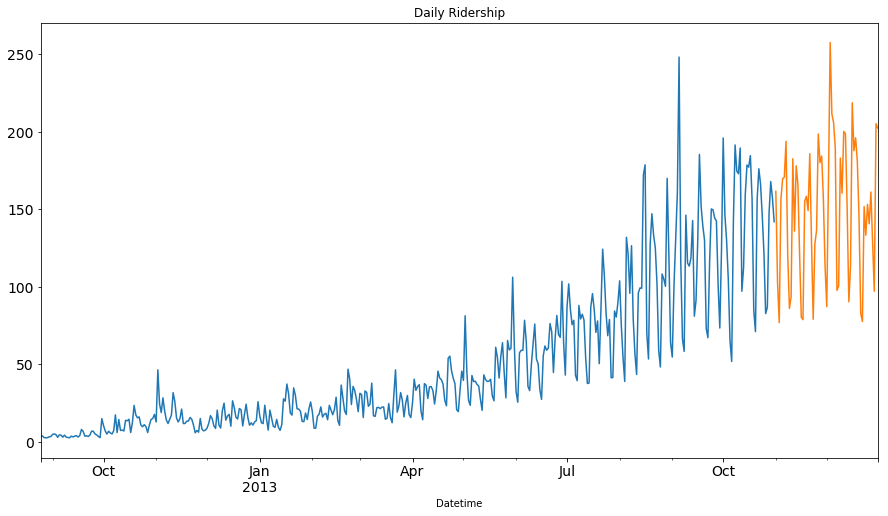

In [26]:
train.Count.plot(figsize=(15,8),title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8),title= 'Daily Ridership', fontsize=14)

# Naive Approach
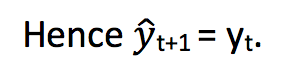
### simply take the last day value and estimate the same value for the next day

In [ ]:
dd=np.asarray(train.Count)

In [ ]:
y_hat=test.copy()

In [ ]:
y_hat["naive"]=dd[len(dd)-1]

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(train.index,train["Count"],label="train")
plt.plot(test.index,test["Count"],label="test")
plt.plot(y_hat.index,y_hat["naive"],label="naive approach")

plt.legend(loc='best')
plt.title("Naive Forecast")


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

# Simple Average
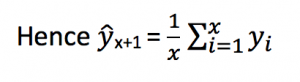
### We take all the values previously known, calculate the average and take it as the next value.

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')

plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
print(rms)

# Moving Average
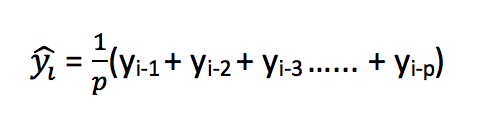
### we forecast the next value(s) in a time series based on the average of a fixed finite number ‘p’ of the previous values. Thus, for all i > p

In [ ]:
y_hat_avg = test.copy()

In [ ]:
train['Count'].rolling(60).mean().iloc[-1]

In [ ]:
train.iloc[373:,1].mean()

In [ ]:
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(60).mean().iloc[-1]

In [ ]:
y_hat_avg.head(2)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.moving_avg_forecast))
print(rms)

# Simple Exponential Smoothing
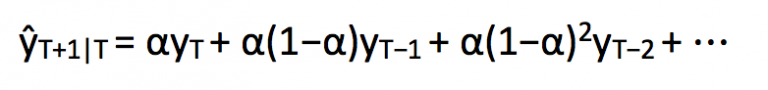

### Exponential smoothing is a rule of thumb technique for smoothing time series data using the exponential window function. 

### Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations:

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()


In [ ]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
print(rms)

# Holt’s Linear Trend method
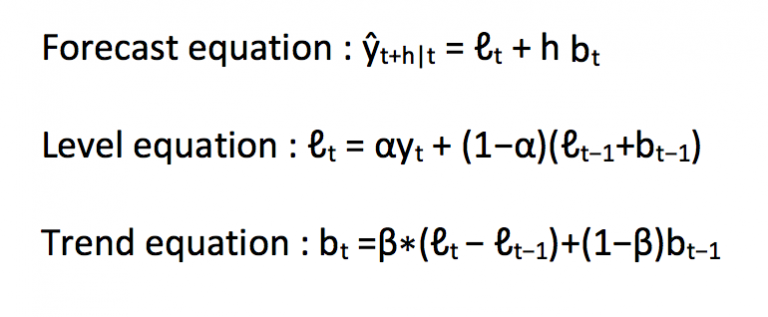
### This method involves a forecast equation and two smoothing equations (one for the level and one for the trend)

In [ ]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

In [ ]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_linear))
print(rms)

# Holt-Winters Method
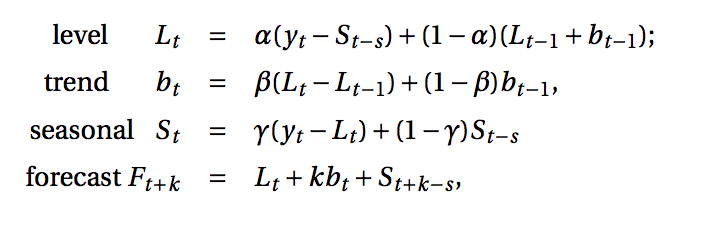

In [ ]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()


In [ ]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print(rms)


# AutoRegressive Integrated Moving Average(ARIMA)
### ARIMA models aim to describe the correlations in the data with each other

In [ ]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [ ]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
print(rms)

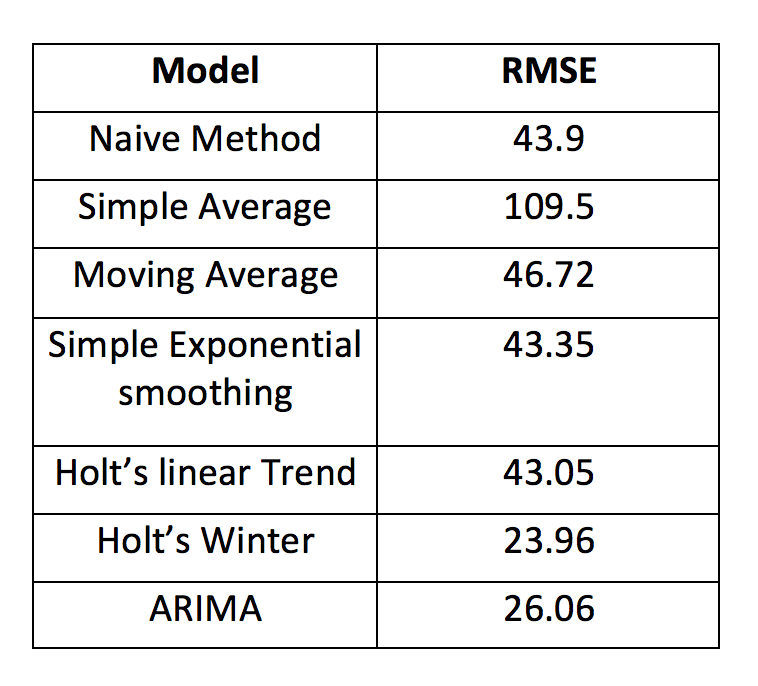